TODO
- Need to figure out metadata
- Specifically, Figure 1, Cron's disease vs non-IBD

In [1]:
!ls ../data/gevers

45568_otu_table.biom	    processing.py
45568_otu_table.qza	    rectum_metadata.txt
biopsy-sample-metadata.txt  rectum_table.txt
collapsed-table.qza	    sample_information_from_prep_1177.tsv
collapsed-table.txt	    sample-metadata.txt
feature-table.biom	    stool_metadata.txt
feature-table.qza	    stool-sample-metadata.txt
gg_13_5_taxonomy.txt	    stool_table.txt
ileum_metadata.txt	    taxonomy.qza
ileum_table.txt


In [2]:
import pandas as pd
import numpy as np
md = pd.read_table('../data/gevers/rectum_metadata.txt', index_col=0)
table = pd.read_table('../data/gevers/rectum_table.txt', index_col=0)

In [3]:
from cmdstanpy import CmdStanModel
from biom import load_table
import pandas as pd
import seaborn as sns
import numpy as np
%matplotlib inline

In [4]:
md['diseasesubtype'].value_counts()

iCD    107
no     107
cCD     48
UC      31
IC      10
CD       6
Name: diseasesubtype, dtype: int64

In [5]:
import os
print(open('nb_diff.stan').read())

data {
  int<lower=0> N;     // number of samples
  int<lower=0> D;     // number of samples
  int<lower=0> p;     // number of covariates
  real depth[N];      // sequencing depths of microbes
  matrix[N, p] x;     // covariate matrix
  int y[N, D];        // observed microbe abundances
}

parameters {
  // parameters required for linear regression on the species means
  matrix[p, D-1] beta;  // covariates
  real<lower=0> disp; // over-dispersion to help control for variance
}

transformed parameters {
  matrix[N, D-1] lam;
  matrix[N, D] lclr;
  vector[N] z;

  z = to_vector(rep_array(0, N));
  lam = x * beta;
  lclr = append_col(z, lam);
}

model {
  // setting priors ...
  disp ~ inv_gamma(1., 1.);
  to_vector(beta) ~ normal(0., 10.); // uninformed prior
  // generating counts
  for (n in 1:N){
    for (d in 1:D){
      target += neg_binomial_2_log_lpmf(y[n, d] | depth[n] + lclr[n, d], disp);
    }
  }
}



In [6]:
from patsy import dmatrix
disease_type = dmatrix("C(diseasesubtype, Treatment('no'))", md, return_type='dataframe')
disease_type.head()

,Intercept,"C(diseasesubtype, Treatment('no'))[T.CD]","C(diseasesubtype, Treatment('no'))[T.IC]","C(diseasesubtype, Treatment('no'))[T.UC]","C(diseasesubtype, Treatment('no'))[T.cCD]","C(diseasesubtype, Treatment('no'))[T.iCD]"
sample_id,,,,,,
1939.MGH100695.a,1.0,0.0,0.0,0.0,1.0,0.0
1939.MGH100695.b,1.0,0.0,0.0,0.0,1.0,0.0
1939.MGH101446,1.0,0.0,0.0,0.0,0.0,1.0
1939.MGH101666,1.0,0.0,0.0,0.0,0.0,0.0
1939.MGH102261,1.0,0.0,0.0,1.0,0.0,0.0


In [7]:
table.shape, disease_type.shape

((309, 113), (309, 6))

In [8]:
import json
nb_data = {
    'N' : len(table),
    'D' : table.shape[1],
    'p' : disease_type.shape[1], 
    'depth' : np.log(table.sum(axis=1)).values.tolist(),  # log of sequencing depth
    'x' : disease_type.values.tolist(),
    'y' : table.values.astype(np.int64).tolist()
}
with open('data.json', 'w') as f:
    json.dump(nb_data, f)

In [9]:
%set_env TBB_CXX_TYPE gcc
nb_model = CmdStanModel(stan_file=os.path.join(os.getcwd(), 'nb_diff.stan'))
nb_vb = nb_model.variational(data='data.json')

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/juermieboop/Documents/interviews/bch/short-introduction-to-ALR/ipynb/nb_diff
INFO:cmdstanpy:start chain 1


env: TBB_CXX_TYPE=gcc


INFO:cmdstanpy:finish chain 1


In [10]:
colnames = np.array(nb_vb.column_names)
beta_idx = np.array(list(map(lambda x: 'beta' in x, colnames)))

In [11]:
beta_samples = nb_vb.variational_sample.iloc[:, beta_idx].values.reshape((
    1000, table.shape[1] - 1, disease_type.shape[1]))

In [12]:
beta_mean = beta_samples.mean(axis=0)
beta_std = beta_samples.std(axis=0)

In [13]:
disease_type.columns.tolist()

['Intercept',
 "C(diseasesubtype, Treatment('no'))[T.CD]",
 "C(diseasesubtype, Treatment('no'))[T.IC]",
 "C(diseasesubtype, Treatment('no'))[T.UC]",
 "C(diseasesubtype, Treatment('no'))[T.cCD]",
 "C(diseasesubtype, Treatment('no'))[T.iCD]"]

In [14]:
ctrl_cd = 1
differentials = pd.DataFrame({
    'mean': [0] + beta_mean[:, ctrl_cd].tolist(), 'std': [0] + beta_std[:, ctrl_cd].tolist()},
    index=table.columns)
differentials = differentials.sort_values('mean')

<ErrorbarContainer object of 3 artists>

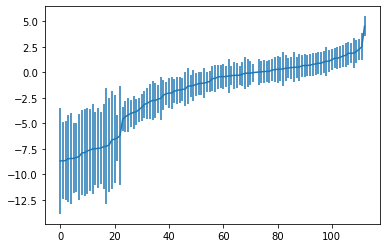

In [15]:
import matplotlib.pyplot as plt
plt.errorbar(np.arange(len(differentials)), differentials['mean'], yerr=differentials['std'])

In [16]:
differentials.head(15)

,mean,std
k__Bacteria;p__Tenericutes;c__Mollicutes;o__RF39;f__;g__,-8.683288,5.195745
k__Bacteria;p__Firmicutes;c__Bacilli;o__Turicibacterales;f__Turicibacteraceae;g__Turicibacter,-8.678904,3.782265
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Anaerostipes,-8.647544,3.837713
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Lachnobacterium,-8.466245,4.270247
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Veillonellaceae;g__Megamonas,-8.446737,4.424322
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Epulopiscium,-8.439803,3.425567
k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__RF32;f__;g__,-8.338626,3.389371
k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__[Weeksellaceae];g__Cloacibacterium,-8.255017,4.215557
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__,-7.892410,4.168171
k__Bacteria;p__Actinobacteria;c__Coriobacteriia;o__Coriobacteriales;f__Coriobacteriaceae;g__Adlercreutzia,-7.883442,4.271919


In [17]:
differentials.tail(15)

,mean,std
k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__;g__,1.079667,1.441719
k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus,1.099120,1.089291
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacteriales;f__Enterobacteriaceae;g__,1.231989,1.027175
k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Neisseriales;f__Neisseriaceae;g__Neisseria,1.379512,1.006584
k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__[Weeksellaceae];g__,1.379848,1.061584
k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Neisseriales;f__Neisseriaceae;g__,1.457733,1.071802
k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Lactococcus,1.595982,1.089014
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae;g__Moraxella,1.651899,1.172904
k__Bacteria;p__Firmicutes;c__Erysipelotrichi;o__Erysipelotrichales;f__Erysipelotrichaceae;g__Coprobacillus,1.860370,1.118723
k__Bacteria;p__Actinobacteria;c__Coriobacteriia;o__Coriobacteriales;f__Coriobacteriaceae;g__Atopobium,1.861283,0.968135


In [20]:
numerator = np.log(table.loc[:, differentials.head(10).index] + 1)
denominator = np.log(table.loc[:, differentials.tail(10).index] + 1)
balance = numerator.mean(axis=1)- denominator.mean(axis=1)
md['TopTaxaLogRatio'] = balance

<AxesSubplot:xlabel='diseasesubtype', ylabel='TopTaxaLogRatio'>

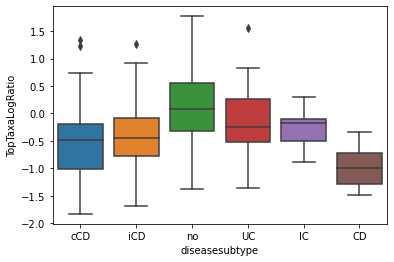

In [21]:
import seaborn as sns
sns.boxplot(x='diseasesubtype', y='TopTaxaLogRatio', data=md)

In [19]:
(differentials['mean'] / differentials['std']).sort_values().tail(10)

k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Neisseriales;f__Neisseriaceae;g__Neisseria             1.370489
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae;g__Moraxella         1.408384
k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Lactococcus                    1.465530
k__Bacteria;p__Firmicutes;c__Erysipelotrichi;o__Erysipelotrichales;f__Erysipelotrichaceae;g__Coprobacillus    1.662941
k__Bacteria;p__Fusobacteria;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae;g__Fusobacterium          1.832848
k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Capnocytophaga     1.875215
k__Bacteria;p__Actinobacteria;c__Coriobacteriia;o__Coriobacteriales;f__Coriobacteriaceae;g__Atopobium         1.922545
k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Oxalobacteraceae;g__                2.187619
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clost

In [18]:
(differentials['mean'] / differentials['std']).sort_values().head(10)

k__Bacteria;p__Verrucomicrobia;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Verrucomicrobiaceae;g__Akkermansia   -3.866824
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__[Odoribacteraceae];g__Butyricimonas              -3.097908
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella                     -3.051983
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__[Paraprevotellaceae];g__Paraprevotella           -3.024158
k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus                     -2.896163
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium    -2.861405
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Christensenellaceae;g__                              -2.601385
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Epulopiscium                      -2.463768
k__Bacteria;p__P

In [22]:
rank = (differentials['mean'] / differentials['std']).sort_values()

numerator = np.log(table.loc[:, rank.head(10).index] + 1)
denominator = np.log(table.loc[:, rank.tail(10).index] + 1)
balance = numerator.mean(axis=1)- denominator.mean(axis=1)
md['TopTaxaLogRatio'] = balance

<AxesSubplot:xlabel='diseasesubtype', ylabel='TopTaxaLogRatio'>

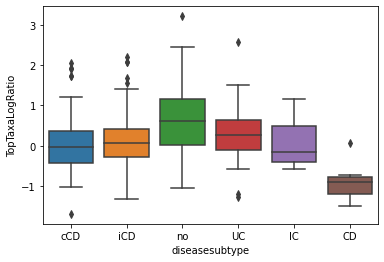

In [23]:
sns.boxplot(x='diseasesubtype', y='TopTaxaLogRatio', data=md)

In [24]:
numerator.columns

Index(['k__Bacteria;p__Verrucomicrobia;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Verrucomicrobiaceae;g__Akkermansia',
       'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__[Odoribacteraceae];g__Butyricimonas',
       'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella',
       'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__[Paraprevotellaceae];g__Paraprevotella',
       'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus',
       'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium',
       'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Christensenellaceae;g__',
       'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Epulopiscium',
       'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__RF32;f__;g__',
       'k__Bacteria;p__Proteobacteria;c__Gammaproteobac

In [25]:
denominator.columns

Index(['k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Neisseriales;f__Neisseriaceae;g__Neisseria',
       'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae;g__Moraxella',
       'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Lactococcus',
       'k__Bacteria;p__Firmicutes;c__Erysipelotrichi;o__Erysipelotrichales;f__Erysipelotrichaceae;g__Coprobacillus',
       'k__Bacteria;p__Fusobacteria;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae;g__Fusobacterium',
       'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Capnocytophaga',
       'k__Bacteria;p__Actinobacteria;c__Coriobacteriia;o__Coriobacteriales;f__Coriobacteriaceae;g__Atopobium',
       'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Oxalobacteraceae;g__',
       'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Veillonellaceae;g__Selenomonas',
       'k__Bacter